In [1]:
import tide_constituents as tc
from py_noaa import coops
import pandas as pd
import numpy as np
import datetime
import tappy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
pd.plotting.register_matplotlib_converters()

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [21]:
start = '20180201'
end = '20180228'
interval = 1

In [22]:
noaa_predict = tc.get_tides(start, end, -88.2, 30.4)

In [23]:
start = pd.to_datetime(start)
end = pd.to_datetime(end)
d = start
w, t, p, r = [], [], [], []

while d < end:
    start_ = d
    end_ = start_ + pd.DateOffset(interval)
    end_ = end_ if end_ < end else end
    water_level, tide = tc.get_water_levels(start_.strftime('%Y%m%d'),
                                            end_.strftime('%Y%m%d'),
                                            -88.2, 30.4)
    water_level = water_level.water_level.astype('float')
    prediction = 0.0 if 'Z0' not in list(tide.speed_dict.keys()) else tide.speed_dict['Z0']
    prediction += sum_signals(tide.key_list, tide.dates, tide.speed_dict, tide.r, tide.phase)
    residual = water_level - prediction
    w.append(water_level)
    t.append(tide)
    p.append(prediction)
    r.append(residual)
    d = end_

In [24]:
water_level = pd.concat(w).to_frame()
water_level.columns = ['observation']
water_level['prediction'] = np.hstack(p)
water_level['residual'] = np.hstack(r)
#water_level = water_level[['water_level', 'prediction', 'residual']]
#water_level.columns = ['observation', 'prediction', 'residual']
water_level = water_level[['observation', 'prediction']]

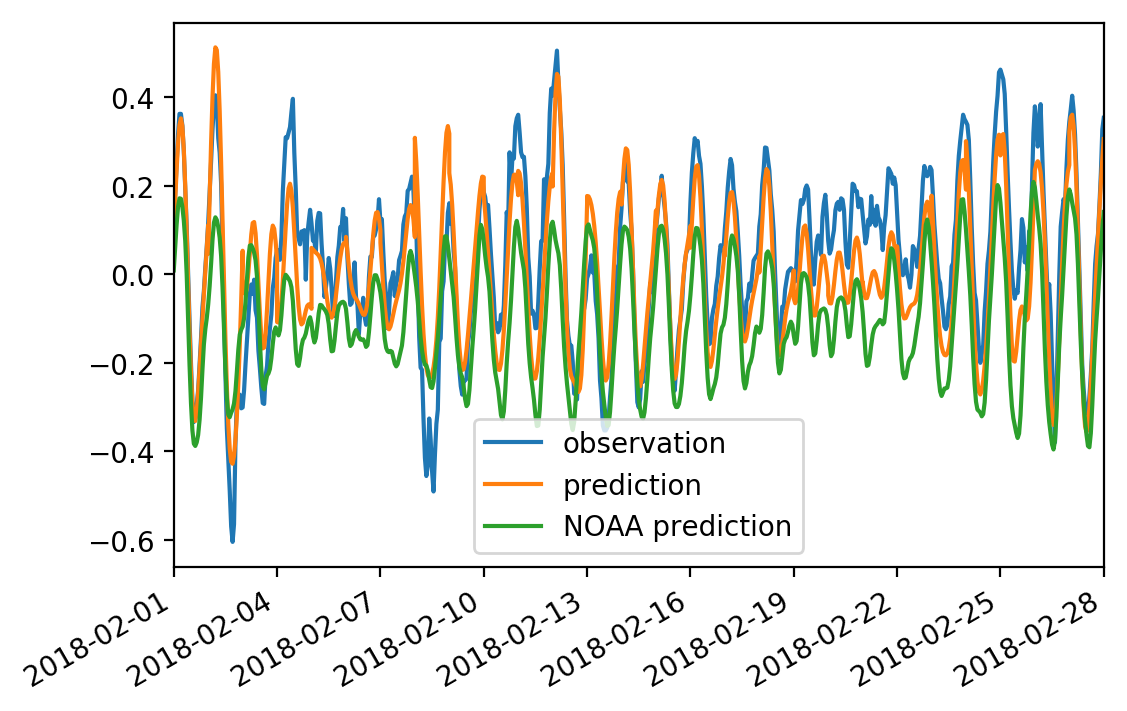

In [30]:
ax = water_level.plot()
noaa_predict.plot(ax=ax)
ax.legend(['observation', 'prediction', 'NOAA prediction'], loc='best')
ax.set_xlabel('');

In [61]:
year = '2018'

In [16]:
start = year + '0101'
start = year + '1231'
data = tc.get_water_levels(start_.strftime('%Y%m%d'),
                           end_.strftime('%Y%m%d'),
                           -88.2, 30.4)

In [18]:
wl = data.predicted_wl.copy()
grouped = wl.groupby(pd.Grouper(freq='M'))

def f(group):
        return pd.DataFrame({'original': group, 'demeaned': group - group.mean()})

wl_demeaned = grouped.apply(f)

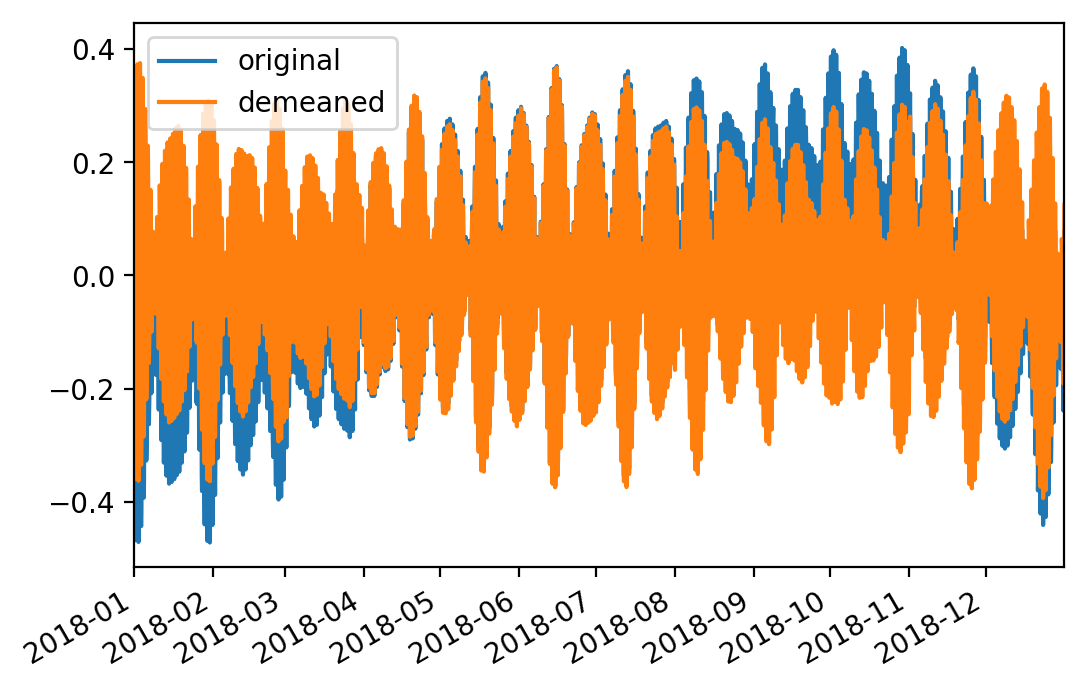

In [19]:
ax = wl_demeaned.plot()
ax.set_xlabel('');

In [31]:
min_month = wl_demeaned.rolling(30).min().groupby(pd.Grouper(freq='M')).last()
max_month = wl_demeaned.rolling(30).max().groupby(pd.Grouper(freq='M')).last()
monthly_minmax = min_month.copy()
monthly_minmax['high'] = max_month['demeaned']
monthly_minmax = monthly_minmax[['demeaned', 'high']]
monthly_minmax.columns = ['low', 'high']
monthly_minmax['range'] = monthly_minmax.high - monthly_minmax.low
ranked = monthly_minmax.sort_values('range')

In [60]:
from calendar import monthrange

low, high = ranked.index[0], ranked.index[1]
for date in [low, high]:
    days = monthrange(date.year, date.month)[1]
    end = date
    start = end - pd.DateOffset(days - 1)

In [ ]:
def predict(data, start, end, interval=1):
    d = start
    p =  []

    while d < end:
        start_ = d
        end_ = start_ + pd.DateOffset(interval)
        end_ = end_ if end_ < end else end
        tide = tc.tide_constituents(data.loc[start_:end_])
        prediction = 0.0 if 'Z0' not in list(tide.speed_dict.keys()) else tide.speed_dict['Z0']
        prediction += sum_signals(tide.key_list, tide.dates, tide.speed_dict, tide.r, tide.phase)
        p.append(prediction)
        d = end_
    